In [4]:
#https://adventuresinmachinelearning.com/python-tensorflow-tutorial/

import numpy as np
from skimage import io
from sklearn import cluster
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
import scipy.stats as stats
import math
import pywt


def remove_hot_pixels(image_stack):
    image_stack[np.isnan(image_stack)] = 0
    image_stack[np.isinf(image_stack)] = 0
    image_stack[image_stack<0] = 0
    a,b,c = np.shape(image_stack)
    img_stack2 = np.zeros((a,b,c))
    for i in range(a):
        im = image_stack[i,:,:]
        im[abs(im)>np.std(im)*10] = 0
        img_stack2[i,:,:] = im
    return img_stack2
        

def flatten(image):
    image[np.isnan(image)] = 0
    image[np.isinf(image)] = 0
    a,b,c = np.shape(image)
    array = np.reshape(image,(a,(b*c)))
    return array
    #print(f'{np.shape(image)} to {np.shape(array)}')
    
def normalize(stack):
    a,b,c = np.shape(stack)
    stack[np.isnan(stack)] = 0
    stack[np.isinf(stack)] = 0
    spec2D_Matrix = flatten(stack)
    norm_stack = np.zeros(np.shape(spec2D_Matrix))
    tot_spec = np.shape(spec2D_Matrix)[1]

    for i in range(tot_spec):
        norm_const = np.max(spec2D_Matrix[:,i])
        norm_spec = spec2D_Matrix[:,i]/norm_const
        if norm_spec.sum() > 0:
            norm_spec = savgol_filter(norm_spec,5,3)
        norm_stack[:,i] = norm_spec
        
    
    norm_stack = np.reshape(norm_stack, (a,b,c))

    return remove_hot_pixels(norm_stack)
    

def Get_sum_spectra(img_stack):
    spec = np.mean(np.mean(img_stack,axis=1),axis=1)
    return (spec)
    
def background1(img_stack):
    img = img_stack[-1]
    img_h = img.mean(0)
    img_v = img.mean(1)
    h = np.gradient(img_h)
    v = np.gradient(img_v)
    bg = np.min([img_h[h == h.max()],img_v[v == v.max()]])
    return bg

def clean_stack(img_stack, auto_bg = False, bg_percentage = 5):
    img_stack = remove_hot_pixels(img_stack)
    a,b,c = np.shape(img_stack)

    if auto_bg == True:
        bg_ = background1(img_stack)
        
    else:
        ref_image = np.reshape(img_stack[-1],(b*c))
        bg_ratio = math.ceil((b*c)*0.01*bg_percentage)
        bg_ = np.max(sorted(ref_image)[0:bg_ratio])
    
    bg = np.where(img_stack[-1]>bg_,img_stack[-1],0)
    bg2 = np.where(bg<bg_,bg,1)
    
    bged_img_stack = img_stack*bg2
    
    return bged_img_stack
    
    
def classify(img_stack,auto_bg = False, bg_percentage = 5, correlation = 'Kendall'):
    a,b,c = np.shape(img_stack)
    img_stack_ = clean_stack(img_stack, auto_bg, bg_percentage)
    norm_img_stack = normalize(img_stack_)
    f = flatten(norm_img_stack)
    
    max_x,max_y = np.where(img_stack[a//2] == (img_stack[a//2].max()))
    #ref = norm_img_stack[:,b//2,c//2]
    ref = norm_img_stack[:,int(max_y),int(max_x)]
    corr = np.zeros(len(f.T))
    for s in range (len(f.T)):
        if correlation == 'Kendall':
            r,p = stats.kendalltau(ref,f.T[s])
        elif correlation == 'Pearson':
            rf = abs(np.fft.fft(ref))
            spec = abs(np.fft.fft(f.T[s]))
            r,p = stats.pearsonr(rf,spec)
            
        corr[s] = r
    
    cluster_image = np.reshape(corr,(b,c))
    #cluster_image[np.isnan(cluster_image)] = 0
    #cluster_image[np.isinf(cluster_image)] = 0
    plt.figure()
    plt.imshow(cluster_image**2)
    return (cluster_image**2), img_stack_


def get_wavelet(spec):
    waveletname = 'morl'
    scales = np.arange(1, 28)
    (wl_data, coeff_d) = pywt.cwt(spec,scales, waveletname,1)
    #plt.imshow(abs(wl_data))
    return (abs(wl_data).reshape(-1))

def wavelet_classifier(img_stack,auto_bg = False, bg_percentage = 5, correlation = 'Pearson'):
    a,b,c = np.shape(img_stack)
    img_stack_ = clean_stack(img_stack, auto_bg, bg_percentage)
    norm_img_stack = normalize(img_stack_)
    f = flatten(norm_img_stack)
    
    ref = norm_img_stack[:,b//2,c//2]
    #ref = Get_sum_spectra(norm_img_stack)
    corr = np.zeros(len(f.T))
    for s in range (len(f.T)):
        if correlation == 'Spearman':
            r,p = stats.spearmanr(get_wavelet(np.diff(ref)),get_wavelet(np.diff(f.T[s])))
        elif correlation == 'Pearson':
            r,p = stats.pearsonr(get_wavelet(np.diff(ref)),get_wavelet(np.diff(f.T[s])))
            
        corr[s] = r
    
    cluster_image = np.reshape(corr,(b,c))
    #cluster_image[np.isnan(cluster_image)] = 0
    #cluster_image[np.isinf(cluster_image)] = 0
    #plt.show()
    return (cluster_image**2), img_stack_


def create_cluster(img_stack,n_clusters, bg_percentage = 5, 
                   auto_bg = False, correlation = 'Pearson', classifier = 'simple'):
    
    if classifier == 'wavelet':
        img, bg_image = wavelet_classifier(img_stack, auto_bg, bg_percentage, correlation)
    elif classifier == 'simple':
        img, bg_image = classify(img_stack, auto_bg, bg_percentage, correlation)
    #img = img_stack.sum(0)
    img[np.isnan(img)] = -99999
    X = img.reshape((-1,1))
    k_means = cluster.KMeans(n_clusters)
    k_means.fit(X)

    X_cluster = k_means.labels_
    X_cluster = X_cluster.reshape(img.shape)+1
    plt.figure()
    plt.imshow(X_cluster)
    plt.title('K_means Cluster Map')
    plt.show()

    fig, axs = plt.subplots(2,n_clusters,figsize=(15,15))
    fig.subplots_adjust(hspace = .5, wspace=0.2)
    axs = axs.ravel()
    
    for i in range(n_clusters):
        mask_i = np.where(X_cluster==(i+1), X_cluster,0)
        spec_i = Get_sum_spectra((bg_image*mask_i))
        axs[i].imshow((bg_image.mean(0)*mask_i), cmap = 'jet')
        axs[i+n_clusters].plot(spec_i)
    
     

C:\Users\pattammattel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\pattammattel\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


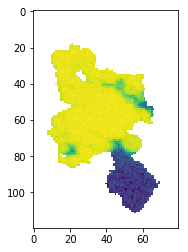

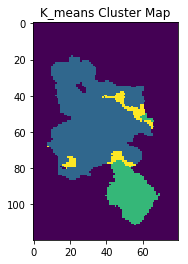

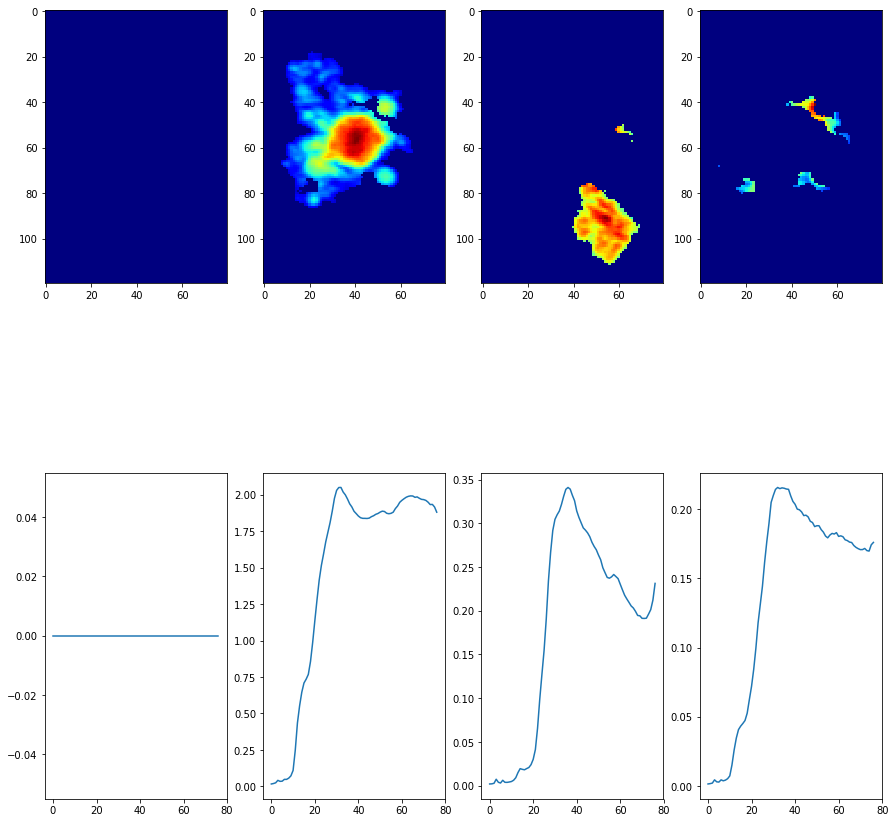

In [6]:
%matplotlib inline
snp = io.imread('mixture_p2.tiff')
create_cluster(snp,n_clusters=4, bg_percentage = 25, auto_bg =True, correlation = 'Pearson')